# Emotion-Semantic Mapping through Wikipedia Article Transitions

This notebook investigates the interplay between semantic shifts and emotional fluctuations as users navigate through Wikipedia articles. The goal is to understand how changes in content affect emotional responses during reading. Our approach begins by calculating semantic distances between consecutive articles using various text embeddings and distance measures, followed by clustering to identify the optimal metric for minimal bias. Next, we employ an emotion prediction model to assign 26 types of emotion scores to each navigation step, adjusting scores to account for reading behavior, such as increased attention on hyperlinks. Finally, we analyze correlations between semantic distance and emotion scores, exploring whether significant semantic shifts provoke specific emotional responses. This study aims to uncover patterns in how users emotionally respond to content transitions, providing insights into human cognitive and affective processing during online navigation.

In [2]:
# Suppress warnings for better readability
import warnings
warnings.filterwarnings('ignore')

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# Semantic analysis scripts
from src.semantic.semantic_utils import (
	load_embedding_data,
	run_all_clustering,
	get_primary_category,
	evaluate_embeddings,
	process_path_data,
	
)

from src.semantic.semantic_visualization import (
	plot_clustering_distribution,
	analyze_semantic_distances,
)

from src.semantic.semantic_paper_utils import (
	process_wikispeedia_data,
)

from src.semantic.semantic_paper_visualization import (
	plot_semantic_network,
	visualize_distance_graph,
	plot_distances_along_path,
)
# Emotion analysis scripts
from src.emotion.emotion_visualization import (
  plot_link_frequencies,
	show_paths_lengths,
	plot_paths_with_random_samples,
	analyze_correlation
)
from src.emotion.emotion_utils import (
  extract_sentences, 
	generate_link_freq_dict,
	extract_path_data,
	calculate_emotion_jump_rates,
)
from src.emotion.emotion_scores import (
	calculate_weighted_emotion_for_single_path,
)
# Correlation scripts
from src.correlation.correlation_utils import (
	calculate_rowwise_correlation,
	mean_correlation,
	process_and_merge_data,
	analyze_and_filter_correlations,
	filter_and_save_csv,
)
from src.correlation.correlation_visualization import (
	plot_scaled_scores,
)

## 1. Explore Different Measures of Semantic Distance

### 1.1. Selecting Best Measure of Semantic Distance through traditional approaches

Semantic distance refers to the similarity or difference in meaning between two concepts, providing a measure of how closely related two ideas are in the context of language comprehension. To ensure a meaningful calculation of semantic distances between Wiki articles, we explored various computational methods. In this section, we introduce traditional methods for computing semantic distance between concepts and evaluate the validity of the results.

We selected two sentence-transformer models for embedding our text:
- [All-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)

    All-MiniLM-L6-v2 maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search. It is a fine-tuned version of the MiniLM-L6-H384-uncased model, designed to generate high-quality sentence embeddings for tasks such as information retrieval, clustering, and sentence similarity. Trained on over 1.17 billion sentence pairs using a self-supervised contrastive learning objective, the model captures semantic relationships between sentences efficiently. Leveraging advanced TPU v3-8 hardware and datasets like Reddit, WikiAnswers, and MS MARCO, it ensures generalizability across diverse contexts. The embeddings produced by the model encapsulate rich semantic information, making it a robust choice for processing and understanding natural language.

- [All-MPNET-Base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2)

    All-MPNET-Base-v2 maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search. It is a fine-tuned version of the microsoft/mpnet-base model, designed to produce high-quality sentence embeddings for tasks such as information retrieval, clustering, and sentence similarity. Fine-tuned on over 1.17 billion sentence pairs using a self-supervised contrastive learning objective, the model learns to capture the semantic relationships between sentences by identifying paired sentences from a randomly sampled set. Developed during the Hugging Face Community Week using JAX/Flax and supported by advanced TPU v3-8 hardware, this model ensures robust performance across diverse language tasks. Its embeddings encode rich semantic information, making it an ideal tool for applications requiring a deep understanding of sentence-level semantics.

The All-MiniLM-L6-v2 model is lightweight and efficient, making it an excellent choice for applications requiring a balance between speed and accuracy. While the All-MPNET-Base-v2 model, on the other hand, leverages the MPNET architecture, which is known for its strong contextual understanding and robust handling of diverse linguistic patterns. By utilizing and comparing these two outstanding models, we aim to achieve comprehensive embedding representations and identify the most effective model to serve as the foundation for our traditional semantic distance representation.

To prepare text data for embedding, we cleaned the HTML data of Wikipedia articles. Since Wiki pages are typically lengthy and cover broad topics, they are not ideal for accurately defining concepts. Therefore, we selected the representative of each article. Given the high dimensionality of the embeddings, clustering became challenging. To address this, we applied PCA to reduce the dimensionality of the embeddings from both models, producing the final representations. The embedding process, implemented in `src/semantic/semantic_paper_preprocessing.py`, consists of the following steps:

1.	Load the HTML data of Wikipedia articles.
2.   Select representative text: Choose the first paragraph. If it has fewer than 20 words, append subsequent paragraphs until the word count reaches 20 or more.
3.  Generate embeddings using All-MiniLM-L6-v2 and All-MPNET-Base-v2.
4.  Apply PCA to reduce dimensionality, ensuring a cumulative explained variance of at least 70%.
5.  Final dimensions: The embeddings from All-MiniLM-L6-v2 were reduced to 80 dimensions, and those from All-MPNET-Base-v2 to 93 dimensions.

#### 1.1.1. Text Embedding

In [2]:
category_file = 'data/original_dataset/wikispeedia_paths-and-graph/categories.tsv'
MiniLM_file = 'data/semantic/pca_MiniLM_dimensions.pkl'
mpnet_file = 'data/semantic/pca_mpnet_dimensions.pkl'

MiniLM_embedding, MiniLM_values = load_embedding_data(category_file, MiniLM_file)
mpnet_embedding, mpnet_values = load_embedding_data(category_file, mpnet_file)

#### 1.1.2. Semantic Measure Evaluation: Clustering on Embeddings

In [ ]:
MiniLM_clustering = run_all_clustering(MiniLM_file, category_file)
mpnet_clustering = run_all_clustering(mpnet_file, category_file)


The clustering results is stored as following structure:

- MiniLM_clustering

    K-Medoids Manhattan: Embeddings (DataFrame)

    K-Medoids Cosine: Embeddings (DataFrame)

- mpnet_clustering

    K-Medoids Manhattan: Embeddings (DataFrame)
    
    K-Medoids Cosine: Embeddings (DataFrame)

In [ ]:
# A sample of clustering results
MiniLM_clustering['K-Medoids_Manhattan'].head(5)

#### 1.1.3. Category-Cluster Mapping and Evaluation

A good clustering result should demonstrate a strong correlation with the predefined categories. To ensure this alignment, we used the degree of association between categories and clusters as the primary evaluation criterion. To streamline the evaluation process, we established a mapping between categories and clusters by counting the number of associations for each pair, sorting them in descending order, and mapping clusters to categories based on this order. The mapping process adhered to the following rules:

1.  Each cluster is assigned to only one category.
2.  Each category is assigned to only one cluster.
3.  Clusters are prioritized for mapping to the categories with the highest association counts.

We selected four metrics for evaluation: **Inter-Cluster Distance**, **Intra-Cluster Distance**, **Purity**, and **Entropy**. These metrics collectively provide a comprehensive evaluation of clustering quality, capturing the spatial distribution of clusters, their internal cohesion, and alignment with ground truth labels.


- **Inter-Cluster Distance**  
  This metric measures the average distance between the centers of different clusters. Higher values are better as they signify greater separation and distinctness between clusters. It is defined as:
  $$
  \text{Inter-Cluster Distance} = \frac{1}{\binom{k}{2}} \sum_{i=1}^{k} \sum_{j=i+1}^{k} d(c_i, c_j)
  $$
  where \(k\) is the number of clusters, \(c_i\) and \(c_j\) are the centroids of clusters \(i\) and \(j\), and \(d(c_i, c_j)\) represents the distance between the two centroids.

- **Intra-Cluster Distance**  
  This metric measures the average distance between points within the same cluster and their respective cluster center. Lower values are better as they indicate tighter, more cohesive clusters. It is defined as:
  $$
  \text{Intra-Cluster Distance} = \frac{1}{k} \sum_{i=1}^{k} \frac{1}{|C_i|} \sum_{x \in C_i} d(x, c_i)
  $$
  where \(C_i\) is the set of points in cluster \(i\), \(c_i\) is the centroid of cluster \(i\), \(x\) is a point in the cluster, and \(d(x, c_i)\) represents the distance between the point and the centroid.

- **Purity**  
  Purity measures the extent to which each cluster contains points from a single ground truth class. Higher values are better as they signify cleaner and more distinct clusters. It is calculated as:
  $$
  \text{Purity} = \frac{1}{N} \sum_{i=1}^{k} \max_j |C_i \cap G_j|
  $$
  where \(N\) is the total number of data points, \(C_i\) is the set of points in cluster \(i\), and \(G_j\) is the set of points in ground truth class \(j\).

- **Entropy**  
  Entropy quantifies the randomness or disorder within the clustering. Lower values are better as they indicate more consistent and cohesive clusters. It is calculated as:
  $$
  \text{Entropy} = -\frac{1}{N} \sum_{i=1}^{k} \sum_{j=1}^{m} \frac{|C_i \cap G_j|}{|C_i|} \log_2 \left( \frac{|C_i \cap G_j|}{|C_i|} \right)
  $$
  where \(m\) is the number of ground truth classes, \(C_i\) is the set of points in cluster \(i\), \(G_j\) is the set of points in ground truth class \(j\), and \(N\) is the total number of data points.

In [ ]:
primary_category = get_primary_category(category_file)

In [ ]:
# Example usage:
MiniLM_eva_df, MiniLM_mapping, MiniLM_evaluation = evaluate_embeddings(MiniLM_clustering, MiniLM_values, primary_category, "MiniLM")
mpnet_eva_df, mpnet_mapping, mpnet_evaluation = evaluate_embeddings(mpnet_clustering, mpnet_values, primary_category, "mpnet")

##### Reasoning:
> **Inter-Cluster Distance**: This metric measures the separation between clusters, with higher values indicating more distinct and well-separated clusters. Across both MiniLM and MPNet embeddings, inter-cluster distances ranged from 0.422 to 0.453. MPNet embeddings with Cosine distance achieved the highest score of 0.453, suggesting superior separation among its clusters. MiniLM embeddings showed slightly lower scores (0.422 for Manhattan and 0.449 for Cosine), indicating less distinction between clusters. Overall, MPNet embeddings performed slightly better, especially when paired with Cosine distance.

> **Intra-Cluster Distance**: Intra-cluster distance evaluates the cohesiveness of clusters, with lower values indicating tighter and more compact clusters. Scores ranged between 0.743 and 0.768 across all configurations. MPNet embeddings with Cosine distance recorded the lowest intra-cluster distance (0.743), demonstrating better internal consistency within clusters. MiniLM embeddings, on the other hand, exhibited higher intra-cluster distances (up to 0.768 with Manhattan distance), indicating more dispersed cluster members.

> **Purity**: Purity measures the alignment between clusters and the ground truth categories, with higher values reflecting cleaner and more accurate clusters. Scores ranged from 0.350 to 0.513. MPNet embeddings with Cosine distance achieved the highest purity (0.513), indicating that these clusters closely aligned with the underlying ground truth categories. MiniLM embeddings struggled with lower purity scores, particularly with Manhattan distance (0.350), showing that the clusters generated were less reflective of the true category structure.

> **Entropy**: Entropy quantifies the randomness within clusters, with lower values representing more consistent and orderly clustering. Across all configurations, entropy ranged from 2.248 to 2.822. MPNet embeddings with Cosine distance achieved the lowest entropy (2.248), indicating the most coherent clusters with minimal overlap. In contrast, MiniLM embeddings with Manhattan distance had the highest entropy (2.822), suggesting significant overlap and less distinct cluster boundaries. These findings further reinforce the superiority of MPNet embeddings in creating clear and organized clusters.

> **Summary**: The differences across the four metrics for the four clustering configurations were not significant, and the overall clustering performance was suboptimal. However, MPNet embeddings consistently outperformed MiniLM embeddings across all metrics, particularly when paired with Cosine distance. Therefore, we ultimately selected MPNet embeddings with Cosine distance for further analysis.

#### 1.1.4. Visualize the clustering result

We present a 2D projection of the clustering results to further evaluate and analyze the quality of the classifications. 

The axes in the 2D plane represent two dimensions of the embedding space, while the colors indicate the clusters to which the points belong.

In [ ]:
plot_clustering_distribution(mpnet_values, mpnet_clustering, mpnet_mapping, d1=0, d2=1)

##### Reasoning
> In the 2D projection, we observed that the boundaries between clusters are poorly defined, with points from different clusters overlapping and appearing nearly randomly distributed. This issue is partly due to the suboptimal clustering results. Additionally, projecting high-dimensional data onto a 2D plane is inherently challenging, as it inevitably involves the loss of information from the other dimensions, resulting in significant distortion and a lack of structural clarity.

##### Limitations and Improvements of Traditional Semantic Distance
Based on the results above, we conclude that traditional methods for representing semantic distance are suboptimal and have limited feasibility. The potential reasons for these shortcomings are outlined below:

> **Insufficient Embedding Representation**: Embedding models are trained on diverse datasets and designed for specific tasks. While the selected embedding models effectively capture semantic information, they may struggle to accurately represent the content of wiki articles or to differentiate between categories in the clustering task.

> **Challenges of Clustering in High-Dimensional Space**: Despite applying PCA for dimensionality reduction, the embeddings still retain 80 to 93 dimensions. High-dimensional data often suffers from the "curse of dimensionality," where distance metrics such as Euclidean or cosine distances lose effectiveness. This limitation poses a significant challenge to using high-dimensional embeddings for clustering.

> **Limitations of the Clustering Algorithm**: The clustering algorithm used has inherent constraints and may not accurately group data based on semantic representations. In this study, we used the K-Medoids algorithm, selected for its compatibility with cosine and Euclidean distance metrics. However, optimizing the clustering algorithm or employing methods better suited for high-dimensional data could significantly enhance clustering performance.

> **Fixed Number of Clusters**: To align with the primary categories, the number of clusters was predefined to match the number of categories. However, this assumption introduces constraints and may not align with the actual distribution of the data, potentially leading to suboptimal clustering results.

> **Limitations of the Evaluation Method**: Using categories as the sole evaluation criterion has inherent limitations, as the original categories represent only one aspect of a wiki article and do not fully capture all the information within the article. Therefore, alternative approaches could be explored to more effectively assess the quality of semantic distance representations.

#### 1.1.5. Visualize the clustering result

In [ ]:
distance_df, path_df, sampled_paths = analyze_semantic_distances(mpnet_embedding, "data/original_dataset/wikispeedia_paths-and-graph/paths_finished.tsv")

#### 1.1.6. Generate semantic distance for all paths

In [ ]:
process_path_data(path_df, distance_df, "data/semantic/semantic_mpnet.csv")

### 1.2. Implementation of paper's distance

this is an attempt at reimplementing the semantic distance between wikipeedia articles presented in [West, Pineau, Precup ; Wikispeedia: An Online Game for Inferring Semantic Distances between Concepts](http://infolab.stanford.edu/~west1/pubs/West-Pineau-Precup_IJCAI-09.pdf)

And we offer a subjective evaluation simulating the human expert evaluation in paper

#### 1.2.1. Implementation

We are interested in $P(A' |A = a, G = g)$: For each article $a'$ that can be reached in one hop from $a$, the probability that a player continues to $a'$ if he/she is currently on $a$ and is trying to find goal article $g$.

This can be estimated from the observed games using standard Bayesian methods, as the mean of the Dirichlet distribution which is the conjugate prior of $P(A' |A = a, G = g)$.

We use $P^*$ to denote the posterior click probability estimated after seeing all the data:

$$P^*(A' = a' |A = a, G = g) = \frac{N(A' = a', A = a, G = g) + \alpha}{N(A = a, G = g) + \alpha L_a}$$

we set the Dirichlet constant to $\alpha = 1/5$
$\alpha$ represents the initial confidence in the uniform prior distribution.

Before observing any games (i.e. if all N-counts are zero) the estimate is the uniform prior click probability: 
$$P_0(A' = a'∣A=a,G=g)=\frac{1}{L_a}$$

We can compute a path-specific distance from every article $a_i$ along $p$ to the goal $g$, i.e. for every $i$ with $1 \leq i < n$ we get: 


$$d_p(a_i,g) = \frac{-\sum_{j=i}^{n-1} \log P^*(A'=a_{j+1}|A=a_j,G=g)}{-\log \text{PageRank}(g)}$$

To get a path-independent distance from a to g, we simply average over all paths running through a and reaching goal g. 

In [ ]:
articles_path = "data/original_dataset/wikispeedia_paths-and-graph/articles.tsv"
paths_path = "data/original_dataset/wikispeedia_paths-and-graph/paths_finished.tsv"
links_path = "data/original_dataset/wikispeedia_paths-and-graph/links.tsv"

process_wikispeedia_data(articles_path, paths_path, links_path, plot=True)

As stated by the original article, a typical anatomy of games is to get away to a hub and then approach the goal. Doing so, we are defining a distance between all the articles in "get away" phase and the goal. However, these articles cannot be assumed to be more related to the goal than a lot other article that are not seen in the dataset. In order to eliminate these distances we need to filter unrelated concepts by cutting the path in the 2 steps *get away to hub* , *then home in on goal*.

The original paper trains a model to predict a cut based on human annotated data as well as the information gain along the path. Since neither the trained model nor the human annotated data are available to us, we simply use the information gain test to find a general value on which to perform this cut.

We can see that the average information gain is dropping up to $\frac{3}{7}^{th}$ of the path before rising.
This clearly distinguishes between the two phases, therefore the cut should be performed at $\frac{3}{7}$ of the normalised path distance.

we recompute the distance by ignoring the *get away to hub* stage.

In [ ]:
visualize_distance_graph(
    main_node="Radio",
    samples=25,
    random_state=19,
    distance_file="data/semantic/distances.csv",
    filtered_file="data/semantic/distances_filtered.csv"
)

The visualization above shows the effect of removing the *get away to hub* phase.
A random set of articles to which we have already defined a distance from article "Radio" have been selected and put around the "Radio" with a graphical distance proportional to their semantic distance. In front of each article the value of d(Radio, article) is written. The articles with red edges are those that have a changed distance after applying the filtering. Then, the green ones represent the changed position of those articles (with an "_CUT" in front of their original name).
Note how relevant ideas like **Telephone** ends up closer to **Radio** after we recomputed the distance without the *get away to hub* articles, while less relevant articles like **Volleyball** doesn't change.

#### 1.2.2. Evaluation

To verify that our implementation of the semantic distance is correct, we rely on our judgement (we are the human annotator) and use visualizations of random distances. The following picture shows an article in the middle (here "Italy") and a set of random articles with defined distances from Italy to them. In front of the name of each article, the measured distance from Italy to them is mentioned. The length of the edges is proportional to the measured distance. 
This kind of graph can help us easily and visually perform a sanity check for the calculated distances. Here, for instance, we can easily identify that closely related topics such as Italian cities are way closer to Italy than unrelated topics such as "Bean."

In [ ]:
plot_semantic_network(
    csv_path="data/semantic/distances_filtered.csv",
    main_node="Italy",
    samples=35,
    random_state=139,
    distance_scale_factor=2.0
)

#### 1.2.3. Plot paper semantic distance for all paths

In [ ]:
plot_distances_along_path()

## 2. Attention Oriented Emotion Labeling

### 2.1. HTML Content Preprocessing and Extraction with Hyperlink Preservation

This part we first extracts semantic segments from HTML files of all webpages, and define and calculate weighted emotion scores based on human reading attentioen on hyperlink and increasing sparsity.

We considered the action of \
•	Lemmatization: Reduces words to their base form (e.g., “running” to “run”). \
•	Stemming: Trims words to their root (e.g., “jumps” to “jump”).

Benefits of Lemmatization and Stemming in Sentiment Analysis

1.	Both lemmatization and stemming reduce words to a common form, which can help models by reducing vocabulary size and focusing on the base meaning of words. For instance, “amazing” and “amazingly” become “amaz,” which may help a simpler model recognize these as similar in sentiment.
2.	Reducing Noise: Variations in verb tenses or plural forms don’t usually impact sentiment. By simplifying “running,” “ran,” and “runs” to “run,” the model can better focus on the emotional content of the words rather than linguistic variations.

Drawbacks of Lemmatization and Stemming

1.	Loss of Nuance: Stemming, in particular, can lead to words losing critical distinctions. For example, “happy” and “happiness” might both be stemmed to “happi,” which removes any slight difference in meaning or intensity that could be relevant to sentiment.
2.	Complicated Sentiment Contexts: Certain suffixes can carry sentiment information. For instance, “help” (neutral) versus “helpful” (positive). Stemming might remove these subtle distinctions, potentially reducing accuracy.

However, for transformer models (e.g., BERT, RoBERTa) or when working with models trained on large datasets, as these models already account for nuanced variations. Modern models handle token variations well, and stemming can reduce performance by discarding subtle context. Therefore, lemmatization alone might be a safer choice than stemming. It preserves word meaning more accurately, while still standardizing some forms. Stemming might only be beneficial for smaller, less nuanced datasets where word reduction is crucial.

Hence, we only perform lemmatization here.

Extracts readable text from HTML content while preserving hyperlinks. The anchor tags in the HTML content will be converted to a format that includes the anchor text and URL in the form `[anchor_text](URL)`. The function splits the text into sentences to make it more aligned with natural reading behavior.

In [ ]:
# Show three html files after extracting sentences
extract_sentences('data/original_dataset/wpcd/wp').head(3) 

### 2.2. Attention Span Weight Calculation

#### 2.2.1. Link Attention Modelling

First we will generate a dictionary the contains the count of each linked link corresponding with each target.

Reasoning:
> To model human attention in navigation, we hypothesize that a human navigator is likely to focus more on links or titles that are relevant to their end goal, or target article. By examining real human behavioral data, we can derive a dictionary that quantifies the frequency of articles encountered on the way to each target article. This dictionary serves as an indicator of the correlation between each intermediate link/title and the target article.

> This correlation relationship gives insight into a human's inclination to choose specific links or titles based on their relevance to the target. In other words, the more frequently an article appears in paths leading to a particular target, the more likely it reflects a natural inclination or preference in human navigation behavior. The unclicked links will share the same ambigutious / preassumed inclination.

In [ ]:
# generate a frequency dictionary of links between articles on user paths, and show one readable example
generate_link_freq_dict('data/original_dataset/wikispeedia_paths-and-graph/paths_finished.tsv')

In [ ]:
# plot the distribution of links frequencies leading to target articles for further exploration
plot_link_frequencies('data/emotion/link_freq_dict.json')

Exponential Distribution of Frequencies: 
 
In each target’s subplot, the frequencies of articles leading to the target display an exponential-like property: a small number of articles have high frequencies, while most other articles appear less frequently. This indicates that users tend to follow a few common paths when navigating to a target, suggesting a strong preference for specific links that are likely perceived as highly relevant to the end goal.

#### 2.2.2. Sentence Weight Assignment

To model user attention, we assume that users are more likely to focus on links within sentences, as these links serve as potential pathways to reach their target. Therefore, sentences containing links (`[ anchor_text ] ( URL )`) are assigned relatively higher weights than those without links, which share a baseline weight.

In addition, we use link click frequency as an indicator of the attention drawn by each link. Links that have been clicked more frequently are likely to be perceived as more relevant or interesting, indicating a higher level of attention from users. Consequently, the weight for each link is proportional to its click frequency, and links with higher click frequencies are assigned greater weights than those with no recorded clicks.

The weight assignment method is formalised as following:

> Mathematical Expression for Sentence Weight Assignment

To model sentence weight based on link presence and click frequency, we define the following:

1. Let $S$ be a sentence.
2. Let $L_i$ represent each link in sentence $S$, where $i = 1, 2, \ldots, n$ (if there are $n$ links in the sentence).
3. Let $f(L_i)$ denote the click frequency of link $L_i$.
4. Let $W_{baseline}$ represent the baseline weight assigned to sentences with no links.

> Weight Assignment Formula

The weight $W(S)$ for sentence $S$ is assigned as follows:

1. **If $S$ contains no links**, assign a baseline weight:
   $$
   W(S) = W_{\text{baseline}}
   $$

2. **If $S$ contains links**, the weight of $S$ is calculated based on a normalized sum of the click frequencies for the links in $S$:
   $$
   W(S) = W_{\text{baseline}} + k \cdot \sum_{i=1}^n \frac{f(L_i)}{\text{\#links for target}}
   $$
   where:
   - $W_{\text{baseline}}$ is the baseline weight for sentences without links.
   - $k$ is a proportionality constant that scales the contribution of click frequency to the overall sentence weight.
   - $f(L_i)$ represents the click frequency of link $L_i$.
   - $\text{\#links for target}$ is the total sum of click frequencies for all links leading to the specified target.


> Explanation of the Formula

- **Baseline Weight $W_{\text{baseline}}$**: Ensures that every sentence has a minimum weight, even if it contains no links.
- **Click Frequency Contribution**: The term $\sum_{i=1}^n k \cdot f(L_i)$ increases the weight for sentences containing links based on how frequently those links are clicked. The higher the frequency $f(L_i)$ for a link, the greater the weight for the sentence, reflecting increased user attention.
- **Normalization Term $\frac{f(L_i)}{\text{\#links for target}}$**: Each link’s frequency $f(L_i)$ is divided by the total click frequency for the target, ensuring that frequencies are comparable across targets with varying link counts.
- **Scaled Contribution**: The normalized click frequencies are scaled by $k$ and summed for each link in the sentence, providing an overall attention weight that reflects user focus based on link relevance and frequency.


This formula prioritizes sentences with high-frequency links, aligning with the assumption that frequently clicked links draw more user attention.

Relevant literature that justifies the choice above: 
> Kahneman, D. (1973). Attention and Effort. Prentice-Hall. This classic work emphasizes that attention is a limited resource and is selectively allocated to elements that are most informative or engaging.

Proportionality Constant ( $k$ ): This value ensures that while links with high click frequencies (popular or frequently chosen links) increase sentence weight significantly, the scaling remains moderate to reflect that human attention, even when selectively focused, tends to spread across multiple cues rather than concentrating exclusively on a single feature.

> Treisman, A. M., & Gelade, G. (1980). A feature-integration theory of attention. Cognitive Psychology, 12(1), 97-136. This study suggests that attention is directed based on feature saliency, but that it distributes across multiple features, particularly in complex tasks.

#### 2.2.3. Handling Backtracking in Path Analysis: Considerations for Emotional Analysis

In analyzing navigation paths, we must consider how to handle backtracking steps (represented by `<`). Backtracking occurs when users navigate back to a previous article, which can provide valuable insights into their exploratory behavior but may also introduce noise. Here, we explore two approaches: **removing backtracking** and **replacing backtracking with the previous article**. Each approach has unique implications for emotional analysis and the relationship between emotion change and semantic distance.

##### 1. Removing Backtracking
In this approach, all instances of `<` are removed from the path, resulting in a streamlined path sequence without backtracking steps.

**Pros**:
- **Cleaner Path Sequence**: Removing backtracking provides a straightforward path, showing only forward progression. This is beneficial when the focus is on direct associations between consecutive articles.
- **Simplified Emotional Analysis**: Without backtracking, emotional analysis can focus purely on the progression of emotions as users encounter new topics. This can make patterns in emotion change easier to identify and analyze.

**Cons**:
- **Loss of Exploration Behavior**: By removing backtracking, we lose information about the user’s exploratory behavior, which might be relevant to understanding emotional responses to content revisitation.
- **Potential Loss of Emotional Nuance**: Backtracking could indicate repeated exposure to emotionally charged topics. Without it, we might miss certain patterns in emotional reactions tied to revisiting previously encountered topics.

##### 2. Replacing Backtracking with the Previous Article
In this approach, each `<` is replaced with the last visited article, effectively duplicating articles in the path to indicate when users revisit content.

**Pros**:
- **Insight into Exploratory Patterns**: This approach preserves the user’s backtracking behavior, which may reveal exploratory or confirmatory patterns. These patterns could indicate deeper engagement with certain topics or themes.
- **Enhanced Emotional Analysis**: Repeated articles in the path allow us to track emotional responses to revisited content, which might reflect sustained or heightened emotions. For example, revisiting a topic with strong emotional content could amplify or stabilize the user’s emotional state.

**Cons**:
- **Increased Path Complexity**: Backtracking introduces additional steps in the path, which could complicate the analysis by increasing the number of steps and potentially diluting clear patterns in emotional progression.
- **Potential Noise in Emotional Trends**: If users frequently backtrack to neutral or less significant content, it could introduce noise in emotional trends, making it harder to distinguish meaningful emotional changes.

##### Relationship Between Emotion Change and Semantic Distance

The choice between removing or preserving backtracking also impacts the analysis of **emotion change in relation to semantic distance** between articles:
- **Removing Backtracking** emphasizes the semantic distance between new topics, allowing us to examine how emotional responses shift with each novel topic encountered.
- **Preserving Backtracking** captures both semantic proximity (revisiting the same topic) and changes over time, allowing for a more detailed study of how repeated exposure to specific content influences emotion.

By analyzing emotion change in conjunction with semantic distance, we can assess how users’ emotions evolve as they navigate through increasingly different (or similar) topics. This approach could reveal patterns such as emotional intensification with greater semantic distance or stabilization with repeated exposure.

In summary, each approach offers unique insights, and the best choice depends on the focus of the analysis:
- **Without Backtracking** is ideal for studying direct emotional progression across diverse topics.
- **With Backtracking** is suitable for understanding how emotional responses are influenced by topic revisitation and exploratory behavior.

In [ ]:
path_df_no_backtracking = extract_path_data('data/original_dataset/wikispeedia_paths-and-graph/paths_finished.tsv', handle_backtracking='remove')
path_df_with_backtracking = extract_path_data('data/original_dataset/wikispeedia_paths-and-graph/paths_finished.tsv', handle_backtracking='replace')

#### 2.2.4. Weighted Emotion Scores

Now that each sentence has an associated emotion label, we can calculate a weighted emotion score for each sentence. This score combines the previously calculated attention weight of the sentence with its emotion label, providing a more nuanced view of the emotional significance based on user attention.

Let:
- $W(S)$ be the attention weight of sentence $S$, calculated as described previously.
- $E(S)$ be the emotion label (or emotion score) associated with sentence $S$.

The weighted emotion score for each sentence $S$ is calculated as:
$$
\text{E}_{weighted}(S) = W(S) \cdot E(S)
$$

This weighted emotion score provides a refined measure that accounts for both the emotional tone of the sentence and the likelihood that it will capture attention.

#### 2.2.5. Increasing Reading Sparsity: Nested Macro Average 

To account for the nature of reading sparsity, we will calculate a **Nested Macro Average** of weighted emotion scores by progressively grouping sentences. This approach reflects the likelihood that readers pay more attention to earlier sentences and progressively less to later sections.

##### Grouping Structure for Nested Macro Average

The weighted emotion scores are grouped as follows:
1. The first sentence alone: $[1]$
2. The second and third sentences together: $[2, 3]$
3. The fourth, fifth, and sixth sentences together: $[4, 5, 6]$
4. The seventh through tenth sentences together: $[7, 8, 9, 10]$
5. Continue grouping in this nested manner, with each subsequent group containing one additional sentence.

##### Steps for Calculating the Nested Macro Average

1. **Calculate the Weighted Emotion for Each Group**: For each group, calculate the average weighted emotion score within the group.
   
2. **Average the Grouped Scores**: After calculating the average for each group, take the average of these grouped scores to obtain the final Nested Macro Average.


Let:
- $W\_E(S_i)$ represent the weighted emotion score of sentence $S_i$.
- Groups are defined as $G_1 = [S_1]$, $G_2 = [S_2, S_3]$, $G_3 = [S_4, S_5, S_6]$, $G_4 = [S_7, S_8, S_9, S_{10}]$, and so forth, with each subsequent group expanding by one additional sentence.

The **Nested Macro Average** is calculated as:
$$
\text{Nested Macro Average} = \frac{1}{k} \sum_{j=1}^k \left( \frac{\sum_{i \in G_j} W\_E(S_i)}{|G_j|} \right)
$$
where:
- $k$ is the total number of groups,
- $G_j$ is the $j$-th group of sentences,
- $|G_j|$ is the number of sentences in group $G_j$,
- $\sum_{i \in G_j} W\_E(S_i)$ represents the sum of weighted emotions within group $G_j$.

This formula averages the weighted emotions within each group and then takes the overall average across groups. By weighting the earlier sentences more heavily, this approach provides a balanced measure that reflects both the emotional tone and the attentional distribution across the article.

In [18]:
# Load the CSV files into DataFrames
unweighted_emotion = pd.read_csv('data/emotion/unweighted_emotion_article.csv')
paths_backtracking = pd.read_csv('data/emotion/extracted_paths_with_backtracking.csv')
paths_nonbacktracking = pd.read_csv('data/emotion/extracted_paths_no_backtracking.csv')
click_frequencies = 'data/emotion/link_freq_dict.json' 
sentences = pd.read_csv('data/emotion/extracted_sentences.csv', index_col=0)
sentences.index = sentences.index.map(lambda x: re.split(r'\.html?$', str(x))[0] if isinstance(x, str) else x) # cases such as U.S._state.htm can be dealed correctly.

In [ ]:
unweighted_emotion.head(1)

we used **roberta-base-go_emotions** for 28 emotion annotation and we consider both human attention span and reading sparsity for each article in each navigation path for each path. And here is an example for one path and one emotion.

In [ ]:
# Test the function with a single path
first_row = paths_backtracking.iloc[0]
target = first_row['target']
path = first_row.drop(labels=['target']).dropna().tolist()

# Calculate the weighted emotions for this single path for the 'surprise' emotion
weighted_path_df = calculate_weighted_emotion_for_single_path(path, target, unweighted_emotion, sentences, click_frequencies, emotion_type='surprise')

print(weighted_path_df)

### 2.3 Result showcase

Now we can do the calculation through all emotions on all paths. For this semester project, we only consider backtracking paths and we only proceed on two emotions: 'surprise' and 'curiosity' for our further discussion. (Each emotion will cause 10+ hours for calculating.)

In [3]:
backtracking_path_weighted_emotions_surprise_df = pd.read_csv('data/emotion/backtracking_path_weighted_emotions_surprise.csv').drop(columns=['path_index'])
backtracking_path_weighted_emotions_curiosity_df = pd.read_csv('data/emotion/backtracking_path_weighted_emotions_curiosity.csv').drop(columns=['path_index'])

In [4]:
backtracking_path_weighted_emotions_surprise_df.head(3) # Display the DataFrame for surprise emotion

,target,Step_1,Step_2,Step_3,Step_4,Step_5,Step_6,Step_7,Step_8,Step_9,...,Step_425,Step_426,Step_427,Step_428,Step_429,Step_430,Step_431,Step_432,Step_433,Step_434
0,African_slave_trade,0.000339,0.000287,0.000306,0.000208,0.000251,0.000211,0.000292,0.000272,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,African_slave_trade,0.000339,0.000246,0.000292,0.000272,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,African_slave_trade,0.000339,0.000291,0.000337,0.000289,0.000186,0.000292,0.000272,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 2.3.1. Showcase by differnt length

In [5]:
# we print out the portion of lengths of the paths to see the distribution, and we select a reasonable range to showcase for the rest of the analysis
show_paths_lengths(backtracking_path_weighted_emotions_surprise_df, start_step=1, end_step=10)

Path lengths:
Length of paths 2: 798
Length of paths 3: 3424
Length of paths 4: 8558
Length of paths 5: 10941
Length of paths 6: 8137
Length of paths 7: 5868
Length of paths 8: 3954
Length of paths 9: 2650
Length of paths 10: 1713


We chose the length of paths from 4 to 7 for further analysis. We first randomly draw 10 samples of each size (those samples are aligned with the semantic distance by setting the seeding the same)

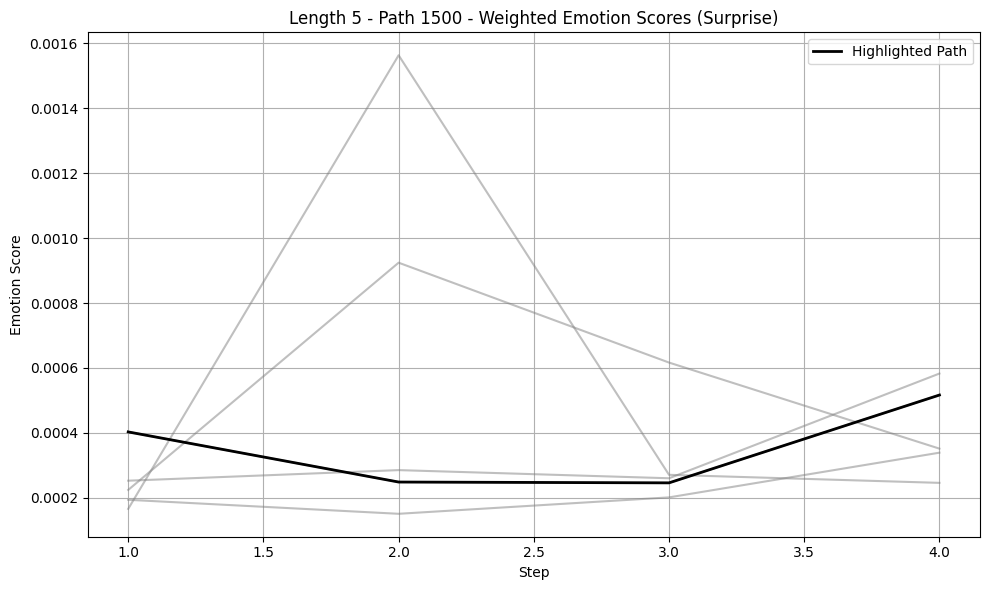

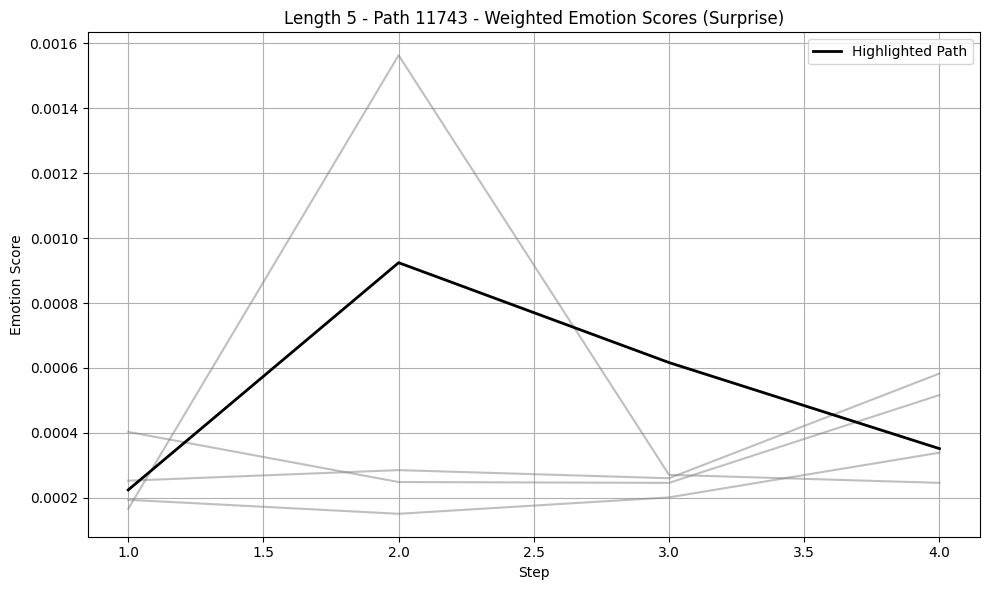

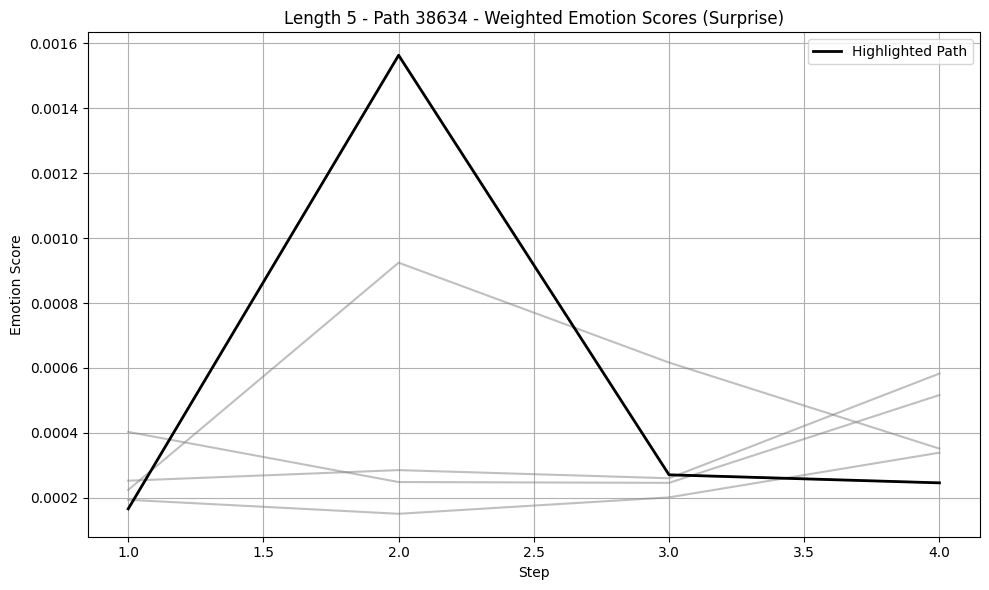

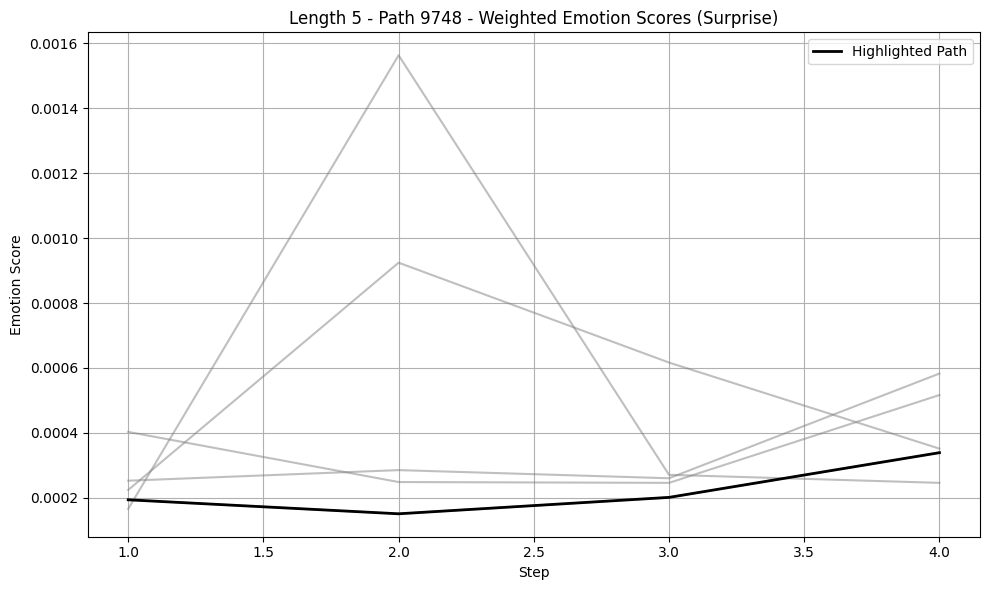

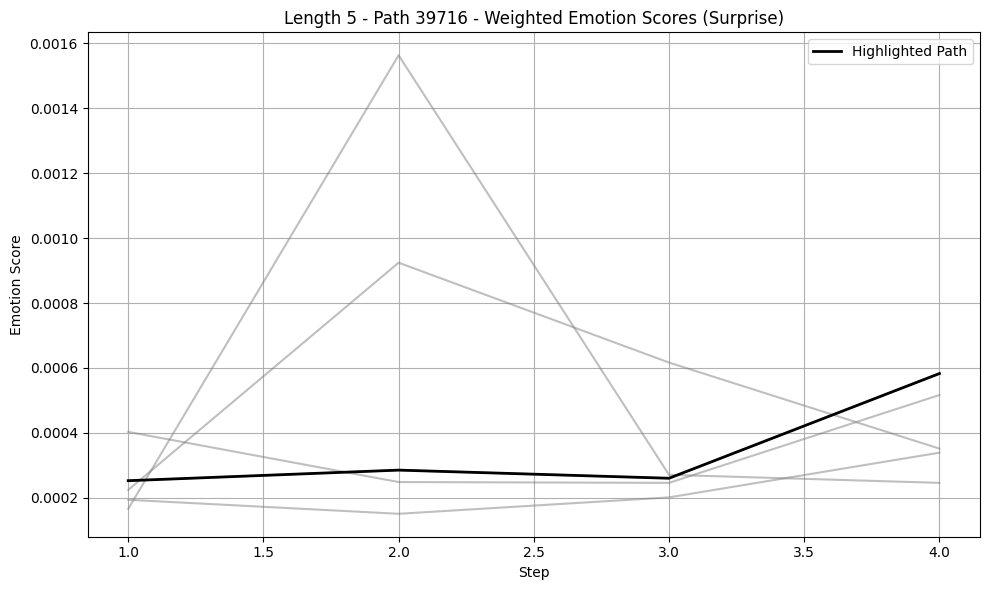

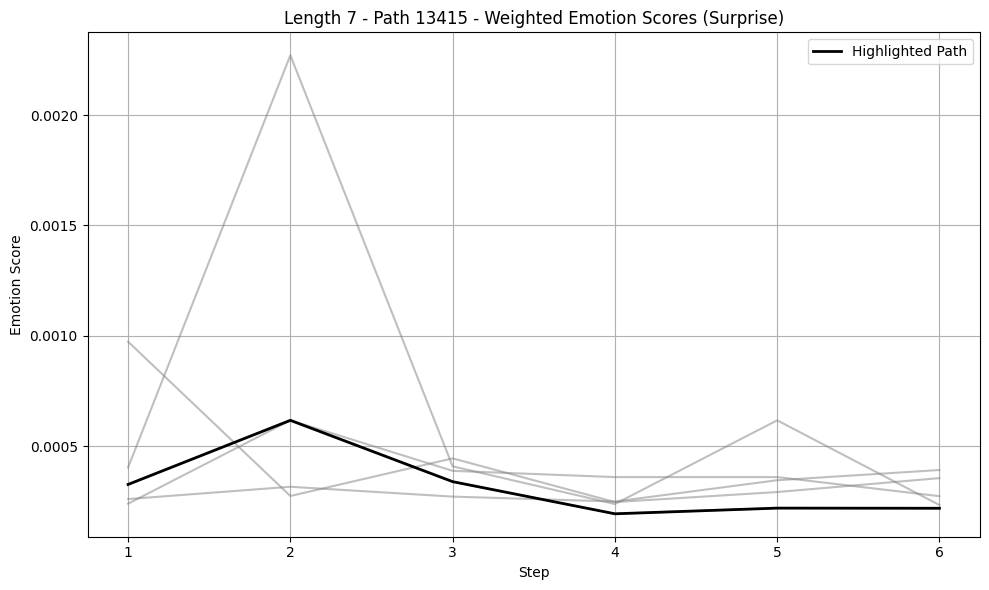

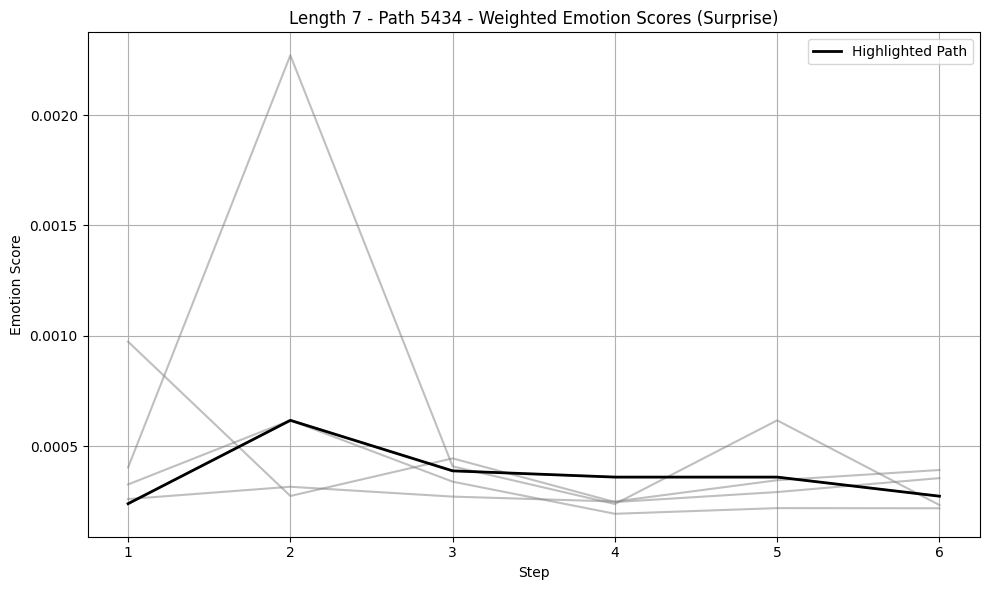

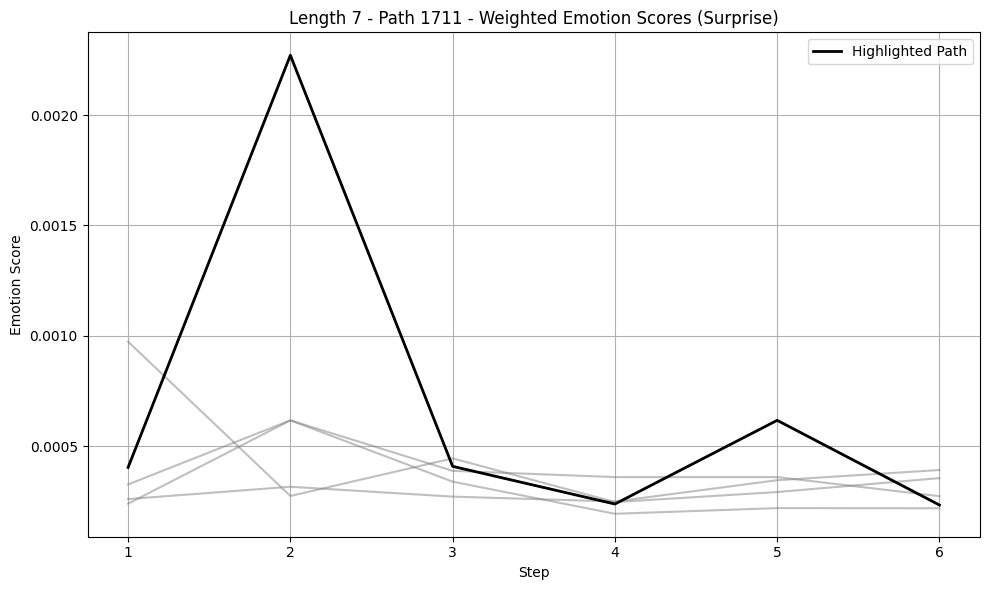

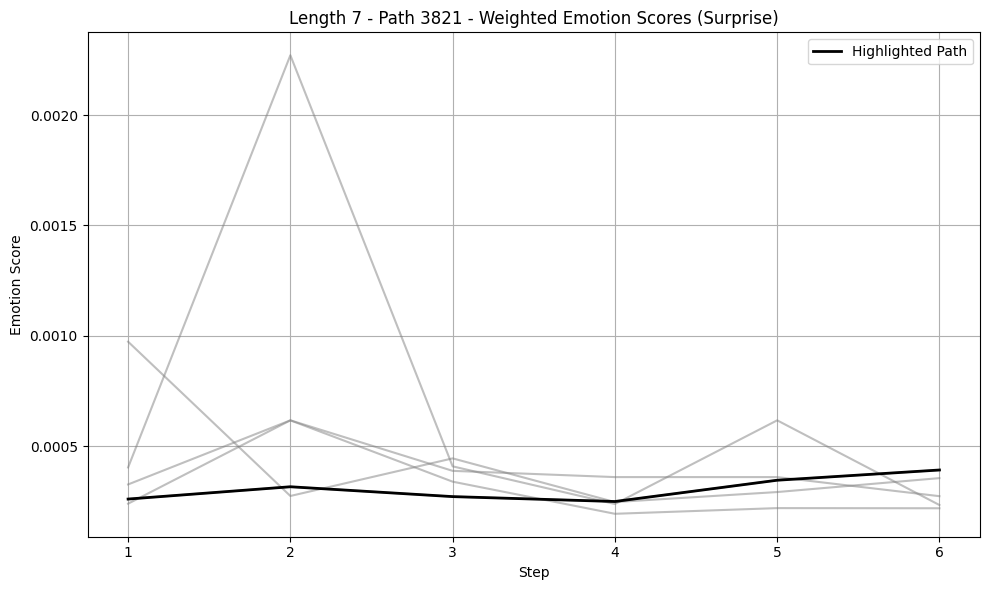

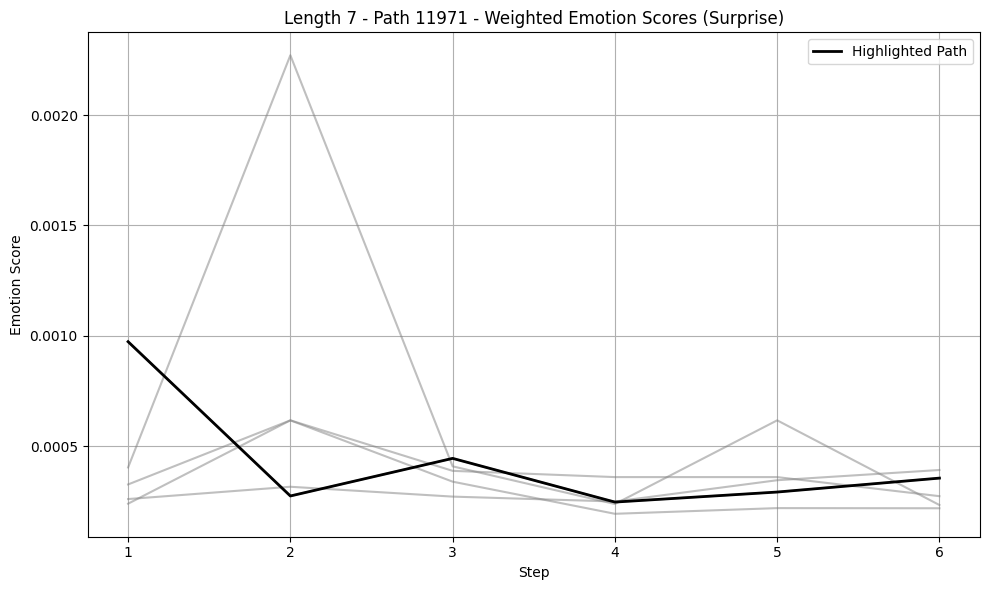

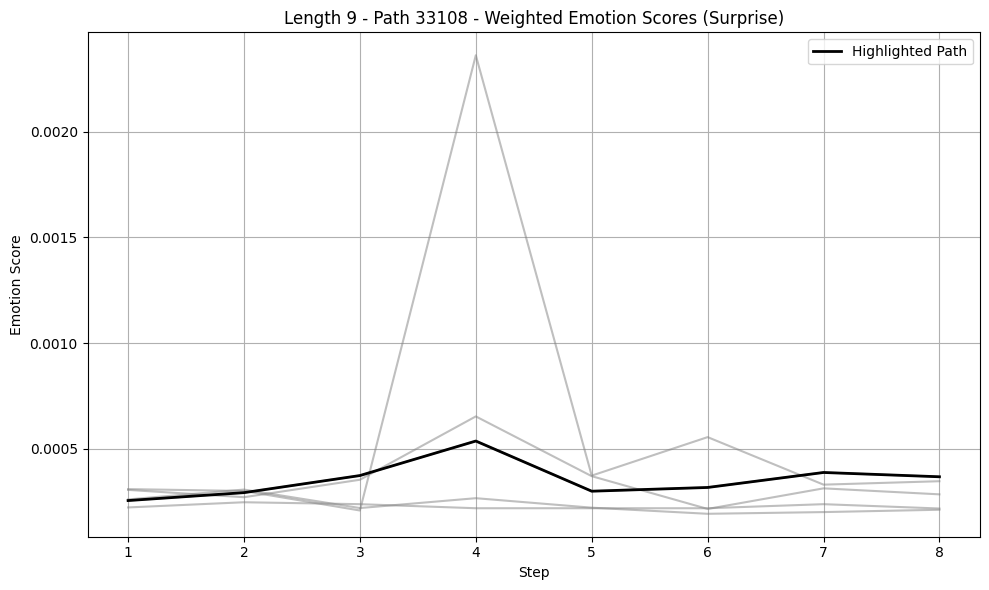

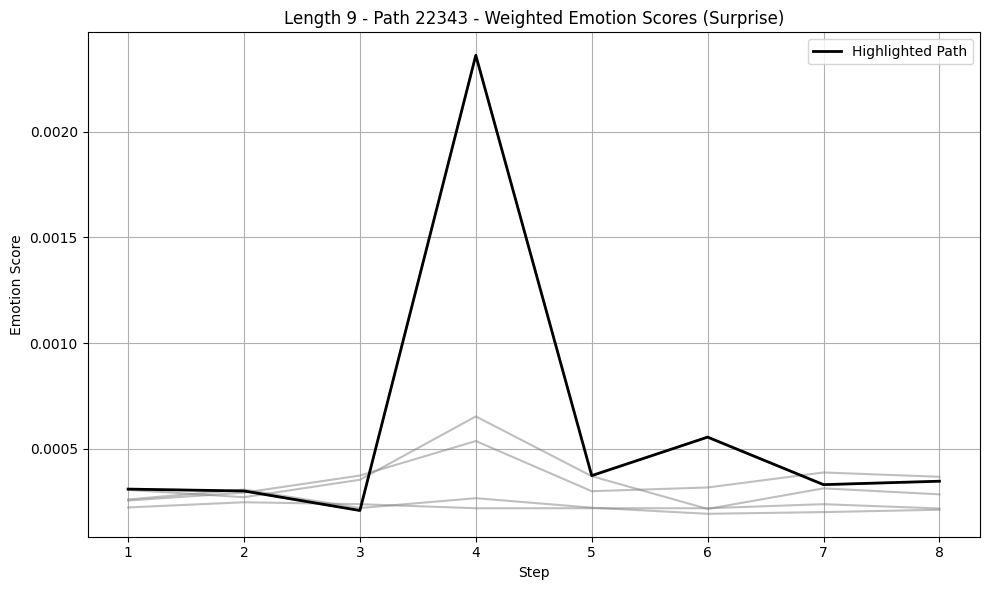

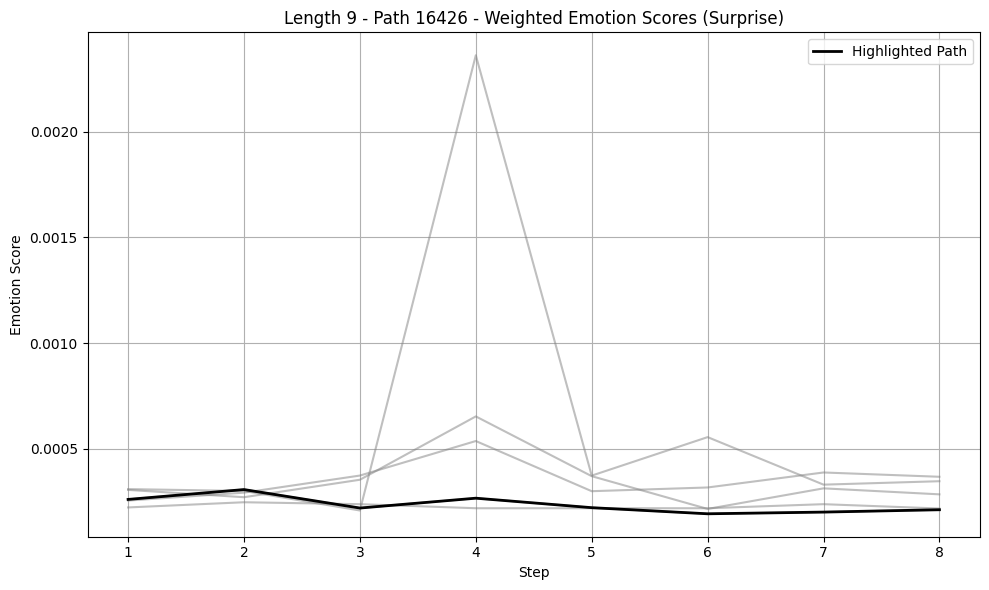

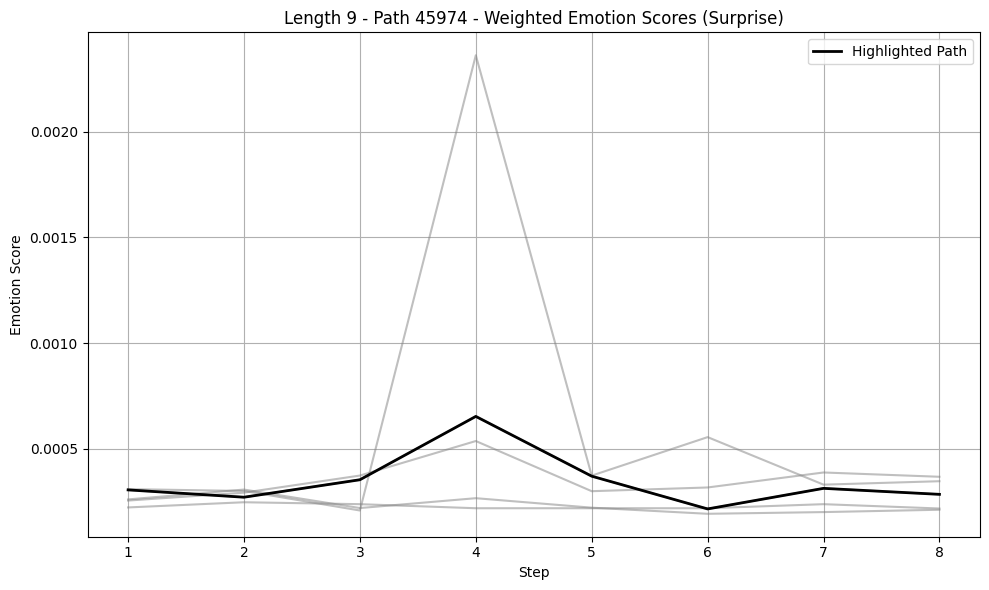

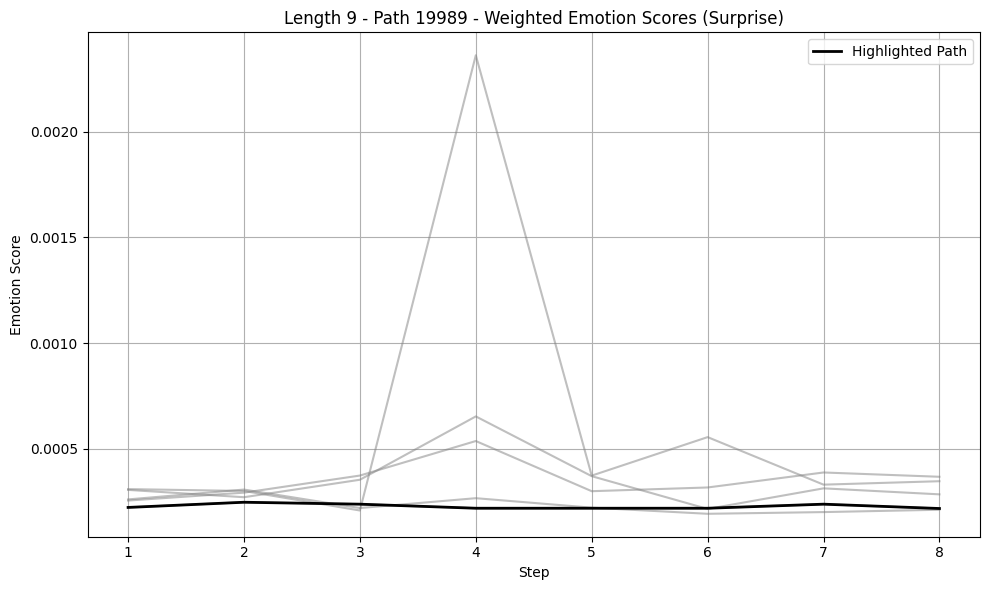

In [6]:
plot_paths_with_random_samples(backtracking_path_weighted_emotions_surprise_df, emotion_label="Surprise", lengths=[5, 7, 9])


#### 2.3.2. Showcase of correlation of emotions

In [7]:
# Analyze the correlation between emotions in navigation paths.
analyze_correlation(backtracking_path_weighted_emotions_surprise_df, 
    backtracking_path_weighted_emotions_curiosity_df, 
    high_corr_threshold=0.7)

Top 5 num_steps values with the highest count of highly correlated routes:
   num_steps  count
0          3   4360
1          4   3445
2          2   3424
3          5   1826
4          6   1113


{'num_highly_correlated_routes': 15781,
 'surprise_high_corr_portion': 0.21893995803154404,
 'curiosity_high_corr_portion': 0.21893995803154404,
 'top_5_high_steps':    num_steps  count
 0          3   4360
 1          4   3445
 2          2   3424
 3          5   1826
 4          6   1113}

As we can see lengths 4,5,6 all have descent portion.
we can scale it to more.

#### 2.3.3. Emotion Jump

In [8]:
#Surprise
data_path_surprise = 'data/emotion/surprise_emotion_relative_jump_rates.csv' # output path
surprise_jump_df = calculate_emotion_jump_rates(
    backtracking_path_weighted_emotions_surprise_df, 'Surprise', data_path_surprise
)

#Curiosity
data_path_curiosity = 'data/emotion/curiosity_emotion_relative_jump_rates.csv' # output path
curiosity_jump_df = calculate_emotion_jump_rates(
    backtracking_path_weighted_emotions_curiosity_df, 'Curiosity', data_path_curiosity
)

Saved: data/emotion/surprise_emotion_relative_jump_rates.csv
   small_jumps_rate  medium_jumps_rate  large_jumps_rate
0              0.29               0.71              0.00
1              0.33               0.67              0.00
2              0.17               0.67              0.17
3              0.50               0.50              0.00
4              0.20               0.40              0.40
Saved: data/emotion/curiosity_emotion_relative_jump_rates.csv
   small_jumps_rate  medium_jumps_rate  large_jumps_rate
0              0.14               0.57              0.29
1              0.00               0.67              0.33
2              0.00               0.33              0.67
3              0.00               0.00              1.00
4              0.20               0.40              0.40


## 3. Correlation

In [9]:
semantic_mpnet = pd.read_csv('data/semantic/semantic_mpnet.csv')
semantic_paper = pd.read_csv('data/semantic/semantic_paper.csv')
backtracking_path_weighted_emotions_surprise_df = pd.read_csv('data/emotion/backtracking_path_weighted_emotions_surprise.csv').drop(columns=['path_index'])
backtracking_path_weighted_emotions_curiosity_df = pd.read_csv('data/emotion/backtracking_path_weighted_emotions_curiosity.csv').drop(columns=['path_index'])


In [10]:
mpnet_surprise_correlation_df = calculate_rowwise_correlation(semantic_mpnet, backtracking_path_weighted_emotions_surprise_df, drop_columns1=['hashedIpAddress'], drop_columns2=['target'])
print("surprise - semantic_mpnet correlation: ")
print(mpnet_surprise_correlation_df.head(5))

mpnet_curiosity_correlation_df = calculate_rowwise_correlation(semantic_mpnet, backtracking_path_weighted_emotions_curiosity_df, drop_columns1=['hashedIpAddress'], drop_columns2=['target'])
print("curiosity - semantic_mpnet correlation: ")
print(mpnet_curiosity_correlation_df.head(5))

paper_surprise_correlation_df = calculate_rowwise_correlation(semantic_paper, backtracking_path_weighted_emotions_surprise_df, drop_columns1=[''], drop_columns2=['target'] + [f"Step_{i}" for i in range(406, 435)])
print("surprise - semantic_paper correlation: ")
print(paper_surprise_correlation_df.head(5))

paper_curiosity_correlation_df = calculate_rowwise_correlation(semantic_paper, backtracking_path_weighted_emotions_curiosity_df, drop_columns1=[''], drop_columns2=['target'] + [f"Step_{i}" for i in range(406, 435)])
print("curiosity - semantic_paper correlation: ")
print(paper_curiosity_correlation_df.head(5))

surprise - semantic_mpnet correlation: 
   correlation
0    -0.078314
1     0.375841
2     0.136325
3    -0.999775
4    -0.067875
curiosity - semantic_mpnet correlation: 
   correlation
0    -0.242703
1    -0.947391
2    -0.078719
3     0.629995
4     0.638029
surprise - semantic_paper correlation: 
   correlation
0    -0.378012
1     0.335496
2    -0.238844
3    -0.856621
4    -0.213366
curiosity - semantic_paper correlation: 
   correlation
0     0.429837
1    -0.421253
2     0.350802
3     0.117968
4    -0.341099


In [11]:
print("mpnet_surprise_correlation:")
mean_correlation(mpnet_surprise_correlation_df, name="correlation")
print("mpnet_curiosity_correlation:")
mean_correlation(mpnet_curiosity_correlation_df, name="correlation")
print("paper_surprise_correlation:")
mean_correlation(paper_surprise_correlation_df, name="correlation")
print("paper_curiosity_correlation:")	
mean_correlation(paper_curiosity_correlation_df, name="correlation")


mpnet_surprise_correlation:
correlation Mean correlation: 0.07817579814201782
mpnet_curiosity_correlation:
correlation Mean correlation: 0.03515810525012124
paper_surprise_correlation:
correlation Mean correlation: 0.053453381217478536
paper_curiosity_correlation:
correlation Mean correlation: 0.051596882339347755


In [12]:
merged_df = process_and_merge_data(
    "data/original_dataset/wikispeedia_paths-and-graph/paths_finished.tsv",
    "data/correlation/merged_df.csv",
    mpnet_surprise_correlation_df, mpnet_curiosity_correlation_df, 
    paper_surprise_correlation_df, paper_curiosity_correlation_df, 
    surprise_jump_df, curiosity_jump_df
)


In [13]:
analyze_and_filter_correlations(merged_df)

Percentage of rows where surprise conditions are met: 18.13%
Percentage of rows where curiosity conditions are met: 17.65%
Percentage of rows where combined conditions are met: 10.06%
                                                  path  path_length  \
617  Animation;The_Lion_King;Television;Technology;...            5   
667  Ant;South_Africa;Europe;World_War_II;Adolf_Hitler            5   
851       Arithmetic;Algorithm;Clock;Solar_System;Moon            5   

     mpnet_surprise_corr  mpnet_curiosity_corr  paper_surprise_corr  \
617             0.807365              0.989777             0.720161   
667            -0.961531              0.843587            -0.931631   
851             0.769683              0.730088             0.980364   

     paper_curiosity_corr  surprise_small_jumps_rate  \
617              0.933985                       0.00   
667              0.792455                       0.00   
851              0.935903                       0.33   

     surprise_medium_

In [14]:
mean_correlation(merged_df[merged_df['path_length'] == 5], name="mpnet_surprise_corr")
mean_correlation(merged_df[merged_df['path_length'] == 5], name="mpnet_curiosity_corr")
mean_correlation(merged_df[merged_df['path_length'] == 5], name="paper_surprise_corr")
mean_correlation(merged_df[merged_df['path_length'] == 5], name="paper_curiosity_corr")


mpnet_surprise_corr Mean correlation: 0.07722388028197108
mpnet_curiosity_corr Mean correlation: 0.03771758495870963
paper_surprise_corr Mean correlation: 0.044273762648880936
paper_curiosity_corr Mean correlation: 0.052259397008733416


In [15]:
mean_correlation(merged_df[merged_df['path_length'] == 3], name="mpnet_surprise_corr")
mean_correlation(merged_df[merged_df['path_length'] == 3], name="mpnet_curiosity_corr")
mean_correlation(merged_df[merged_df['path_length'] == 3], name="paper_surprise_corr")
mean_correlation(merged_df[merged_df['path_length'] == 3], name="paper_curiosity_corr")


mpnet_surprise_corr Mean correlation: -0.12088502611691108
mpnet_curiosity_corr Mean correlation: 0.17462568435393586
paper_surprise_corr Mean correlation: -0.14927875713442562
paper_curiosity_corr Mean correlation: 0.07218321584122274


In [16]:
filtered_df = filter_and_save_csv('data/correlation/selected_path_lengths_df.csv', [2136, 2140, 2173, 2212], 'data/correlation/casestudy.csv')

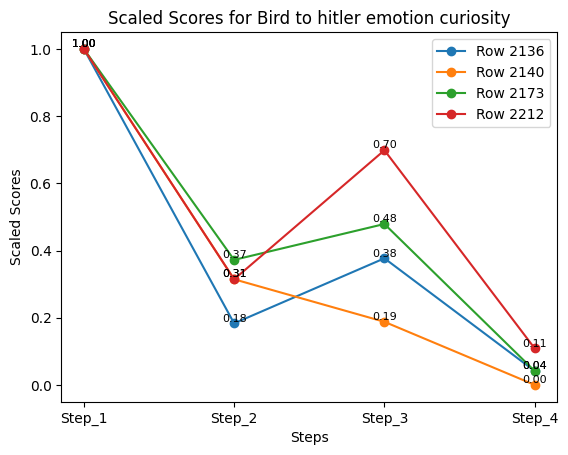

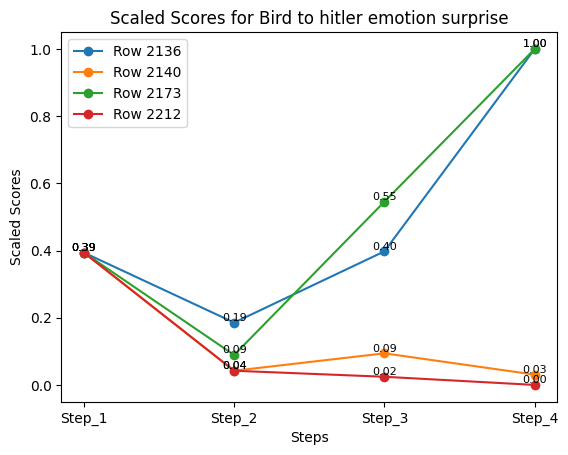

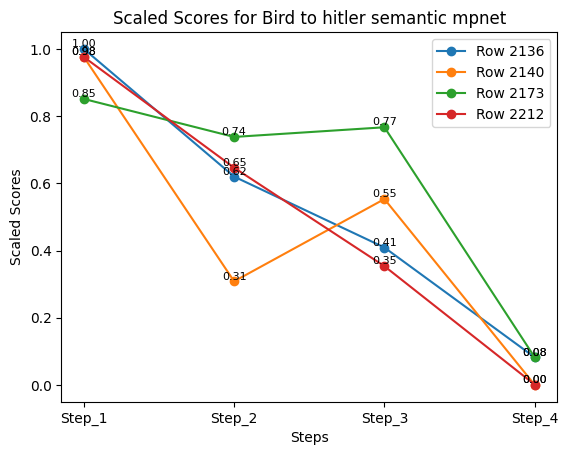

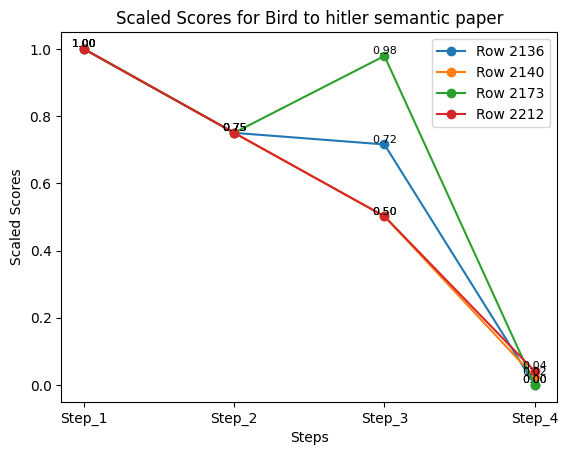

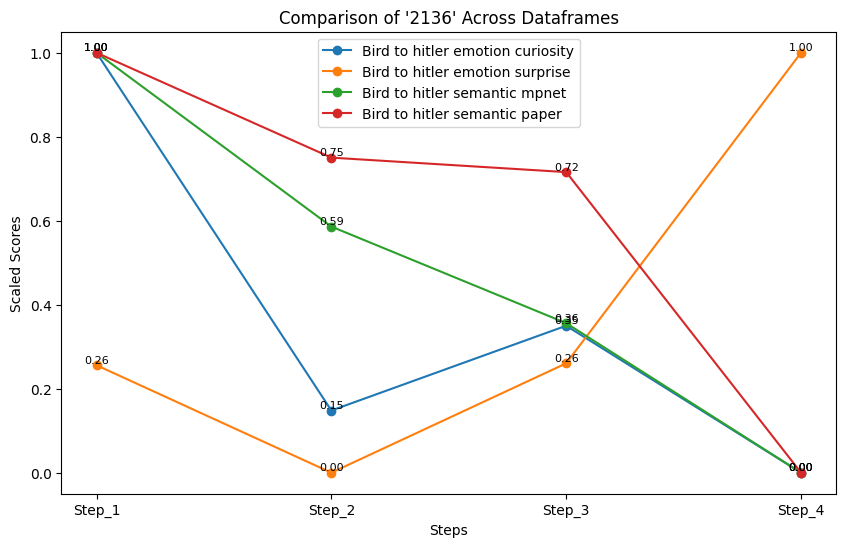

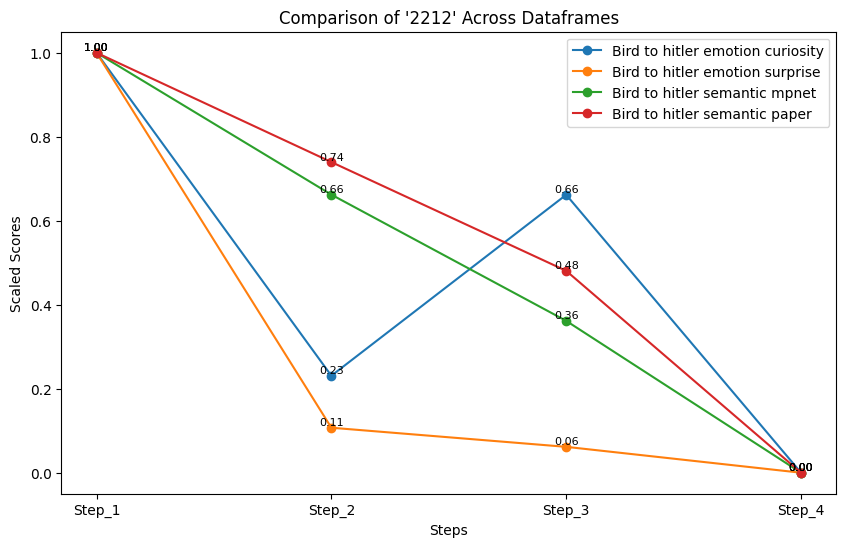

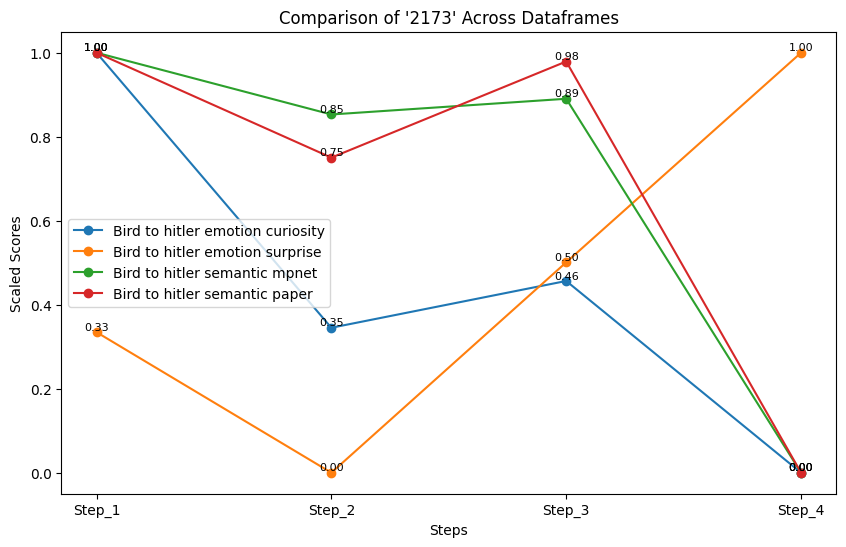

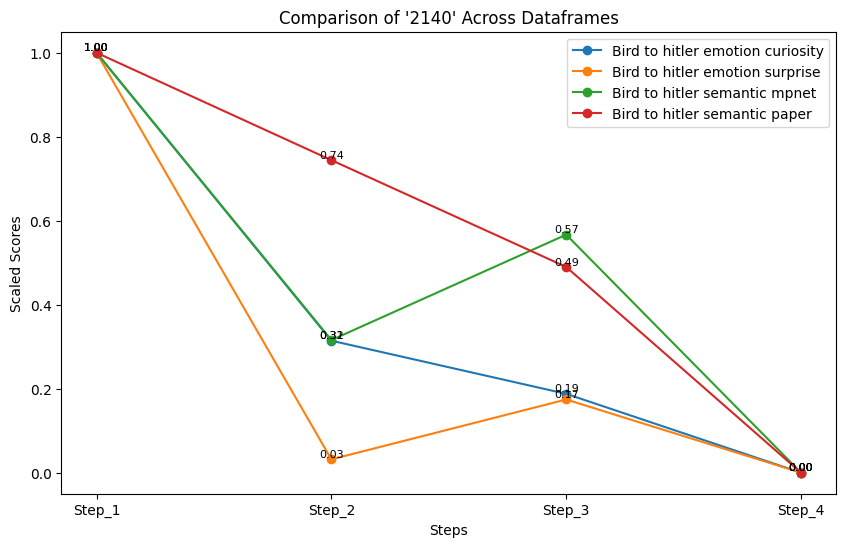

In [17]:
plot_scaled_scores()